# Extract Training, Validation and Testing Datasets for Machine Learning

This code takes geomagnetic field, modelled geoelectric field and OMNI data that have been conbined into a single DataFrame and extracts samples for training of machine learning models.

### Steps in this code:

1. **Prepare input data**: Prepare all the input feature and target data.
2. **Pick out stormy and quiet times**: Go through data and get something resembling balance between geomagnetically active times with quiet times.
    2.1. Extract samples for Ex and Ey,<br>
    2.2. Extract samplesfor GIC fits from Ex and Ey.<br>
3. **Write samples for virtual real-time application**: Extract samples so we can see how well the model would have performed if it had been run every 15 minutes throughout these years.
3. **Appendix**: Split the years into training and testing years so they're roughly balanced by activity.

### Input and Output

- Input to this file (df_features.p) was compiled using 1_DataPreparation and is saved in the path given in parameters.json: "datapath".
- The samples for training, testing and for virtual real-time application (assuming code is run every 15 minutes during the periods reserved for testing) are also saved to "datapath" with the prefixes "traindata_", "testdata_" and "rtdata_". Scaling objects (sklearn) are saved alongside under scaler_. Separate files are saved for each possible target (6 in total): Ex_FUR, Ey_FUR, GIC1 and GIC2 measurements (GIC_), and GIC1 and GIC2 fits (GIC_fit_) from the modelled geoelectric field data.
- Plots are saved to "plotpath". 

**Author**: Rachel L. Bailey (ZAMG, r.bailey@zamg.ac.at), Feb 2020 - Aug 2021.

In [1]:
import os
import sys
import time
import copy
from datetime import datetime, timedelta
import json
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num
import pandas as pd
import pickle
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# local
import sw2gic

try:
    import seaborn as sns
    sns.set_style('whitegrid')
except:
    print("No seaborn support.")

print("")
print("")
print("Starting analysis at {}".format(datetime.utcnow()))



Starting analysis at 2021-09-03 08:57:17.186250


# 1. Prepare Input Data

### Input Parameters

These parameters define how the model runs, i.e. how the data is treated before sample selection.

In [2]:
parameter_file = 'parameters.json'
print("Using parameters from {}".format(parameter_file))

with open(parameter_file, 'r') as fp:
    P_LSTM = json.load(fp)
P_LSTM

Using parameters from parameters.json


{'start_date': '1995-01-01',
 'end_date': '2021-01-01',
 'obs': 'FUR',
 'input_tr': 120,
 'output_tr': 40,
 'offset_tr': 10,
 'a_SS1': 0.0377,
 'b_SS1': 0.0319,
 'a_SS5': 0.00444,
 'b_SS5': 0.05552,
 'subtract_daily_avg': False,
 'window_daily_avg': 10,
 'backprop_omni': False,
 'max_E_lim': 200,
 'encode_nodes': 4,
 'batch_size': 8,
 'loss_adj': 0.1,
 'archivepath': '/Volumes/Mnemosyne/Data/',
 'datapath': '/Volumes/Mnemosyne/Data/ML/SW2GIC',
 'plotpath': 'plots',
 'savefig': False,
 'sns_style': 'whitegrid',
 'c_Ex': '#e69f00',
 'c_Ey': '#56b3e9',
 'c_SS1': '#009e73',
 'c_SS5': '#cc79a7'}

#### Create dictionaries to hold all parameters

In [3]:
# Parameters for extracting data and running code
P_LSTM['savefig'] = False
if not os.path.exists(P_LSTM['plotpath']):
    os.mkdir(P_LSTM['plotpath'])
    
# Determine exactly which data to use:
if P_LSTM['obs'] == 'WIC':
    if P_LSTM['subtract_daily_avg']:
        train_on_vars = ['Ex_noqt', 'Ey_noqt']
    else:
        train_on_vars = ['Ex', 'Ey']
else:
    if P_LSTM['subtract_daily_avg']:
        train_on_vars = ['Ex_FUR_noqt', 'Ey_FUR_noqt']
    else:
        train_on_vars = ['Ex_FUR', 'Ey_FUR']
P_LSTM['train_on_x'] = train_on_vars[0]
P_LSTM['train_on_y'] = train_on_vars[1]

ml_data_path = P_LSTM['datapath']
if 'scratch' in os.getcwd():
    ml_data_path = '/scratch-cbe/users/rachel.bailey/data/'
        
start_datacut = datetime.strptime(P_LSTM['start_date'], "%Y-%m-%d")
end_datacut = datetime.strptime(P_LSTM['end_date'], "%Y-%m-%d")
start_datacut, end_datacut = datetime(1995,1,1), datetime(2021,1,1)

In [4]:
# Save to dictionaries for easy access
P_Ex = {}
P_Ey = {}
# Parameters for each variable
P_Ex['variable'] = P_LSTM['train_on_x']
P_Ey['variable'] = P_LSTM['train_on_y']
print("Preparing data for {} and {}.".format(P_Ex['variable'], P_Ey['variable']))

Preparing data for Ex_FUR and Ey_FUR.


#### Define SWEncoder for encoding solar wind features

In [5]:
from sw2gic import SolarWindFeatureEncoder

feature_vars = ['bz', 'by', 'btot', 'speed', 'density']
# Values not quite at the max. measured work best:
max_vals = {'bz' : 50,
            'by' : 50,
            'btot': 60,
            'speed': 1100,
            'density': 60}
min_vals = {'bz' : -50,
            'by' : -50,
            'btot': 0.,
            'speed': 250.,
            'density': 0.}

# Use this to find the values, then hard-wire them so the Encoder never changes:
#for variable in feature_vars:
#    max_vals[variable] = df_features[variable].max()
#    min_vals[variable] = df_features[variable].min()
#    print("Max/min of {}:\t{:.1f} / {:.1f}".format(variable, max_vals[variable], min_vals[variable]))
    
#Max/min of bz:	69.7 / -60.6
#Max/min of by:	57.1 / -50.9
#Max/min of btot:	72.8 / 0.0
#Max/min of speed:	1137.4 / 180.7
#Max/min of density:	72.1 / 0.0
    
P_LSTM['encoding_max'] = max_vals
P_LSTM['encoding_min'] = min_vals

SWEncoder = SolarWindFeatureEncoder(max_vals, min_vals, encode_nodes=P_LSTM['encode_nodes'])

### Read in DataFrame of Features

- ``df_features.p`` is the file compiled using the notebook ``1_DataPreparation.ipynb``.
- ``df_features_proc.p`` is compiled using this code and includes further processing of the data before sampling. This will be loaded by default if the code has been run before, skipping the next few steps (which are computationally heavy).
- ``df_features_backprop_proc.p`` is the same as above but includes OMNI solar wind data that has been back-propagated in time to L1 assuming a static bow shock and constant propagation speed.

In [6]:
if P_LSTM['backprop_omni']:
    filename_start = 'df_features_backprop_proc'
else:
    filename_start = 'df_features_proc'

proc_filename =  "{}_{}_{}.p".format(filename_start, start_datacut.strftime("%Y%m%d"), end_datacut.strftime("%Y%m%d"))
pickled_data_processed = os.path.join(ml_data_path, proc_filename)
if os.path.exists(pickled_data_processed):
    print("Processed data already exists! Reading from pickle file.")
    df_features = pd.read_pickle(pickled_data_processed)
    proc_file_exists = True
else:
    print("Creating new processed DataFrame for data.")
    proc_file_exists = False

if not proc_file_exists:
    # Read in the feature dataframe:
    pickled_data_path = os.path.join(ml_data_path, 'df_features.p')
    df_features_all = pd.read_pickle(pickled_data_path)

    # Cut to smaller dataset for now:
    if df_features_all.index[-1] + timedelta(minutes=1) == end_datacut:
        df_features = df_features_all[start_datacut:end_datacut]
    else:
        df_features = df_features_all[start_datacut:end_datacut][:-1]
    df_features

Processed data already exists! Reading from pickle file.


#### Subtract daily average from target

The median daily variations (taken over a window of 20 days) is subtracted from each day. This is interesting to test in training but the model seems to learn better with data where the daily variation hasn't been subtracted.

In [7]:
if not proc_file_exists:
    for varname in ['Ex', 'Ey', 'Ex_FUR', 'Ey_FUR']:
        varname_noqt = '{}_noqt'.format(varname)
        df_features[varname_noqt] = df_features[varname]
        n_mins_day = 60*24
        # Making this smaller seems to increase the noise but decrease error. 10 seems an ok balance
        window = int(P_LSTM['window_daily_avg']) # days on either side
        for i in range(int(len(df_features)/n_mins_day)): # iterate over days
            extract_win = np.arange((i-window)*n_mins_day,(i+window)*n_mins_day)
            extract_win = extract_win[extract_win >= 0]
            extract_win = extract_win[extract_win < len(df_features)]
            # Subtract median daily variation around every day +/- window
            subtract_median = np.median(df_features.iloc[extract_win][varname].values.reshape((int(len(extract_win)/n_mins_day), n_mins_day)),axis=0)
            df_features.iloc[i*n_mins_day:(i+1)*n_mins_day][varname_noqt] -= subtract_median

    %matplotlib inline

    fig = plt.figure(figsize=(20,5))
    plt.plot(df_features[datetime(2017,9,7):datetime(2017,9,11)]['Ex'], label='Ex')
    plt.plot(df_features[datetime(2017,9,7):datetime(2017,9,11)]['Ex_noqt'], label='Ex_noqt')
    plt.legend()
    plt.show()

#### Back-propagate OMNI data to L1

This will obviously result in some information loss, but that should be primarily on fast variations.

In [11]:
if not proc_file_exists and P_LSTM['backprop_omni']:
    # Radius of the Earth
    R_Earth = 6371. # km
    # Distance at which OMNI data are calculated
    R_OMNI = 14. * R_Earth # km
    # Astronomical units
    AU = 149597870.700 # km 
    # Distance Earth to L1 (technically not a constant)
    dist_to_L1 = 1496547.603 # km
    sw_variables = ['bx', 'by', 'bz', 'btot', 'speed', 'density', 'temp']
    speed = df_features['speed'].interpolate(limit_direction='both').to_numpy()
    r_omni = AU - np.full(speed.shape, R_OMNI)
    r_L1 = AU - np.full(speed.shape, dist_to_L1)
    timeshift = (r_L1 - r_omni)/speed / 60. # in minutes
    timeshift_mins = np.array([timedelta(minutes=x) for x in timeshift])
    
    # Apply new timesteps to index:
    timeshift_mins = np.array([pd.offsets.DateOffset(minutes=x) for x in timeshift])
    df_index_orig = df_features.index
    df_features_timenew = copy.copy(df_features[sw_variables])
    df_features_timenew.index += np.array(timeshift_mins)
    
    # Reindexing to a higher sampling rate would probably be more accurate but much slower
    df_features_backprop = (df_features_timenew
                             .reindex(df_features_timenew.index.union(df_index_orig))
                             .interpolate(method='index', limit=2)
                             .reindex(df_index_orig)
                            )
    
    print("Number of NaNs should stay roughly the same:")
    print("# of NaNs in backpropagated data:", np.count_nonzero(np.isnan(df_features_backprop['speed'])))
    print("# of NaNs in original data:      ", np.count_nonzero(np.isnan(df_features['speed'])))
    
    for varname in sw_variables:
        # Keep the original data:
        df_features[varname+'_OMNI'] = df_features[varname]
        # Make the shifted data the main value:
        df_features[varname] = df_features_backprop[varname]
        
    %matplotlib inline
    
    plt.plot(df_features[datetime(2017,9,6,22):datetime(2017,9,8,8)]['speed_OMNI'], 'b-')
    plt.plot(df_features[datetime(2017,9,6,22):datetime(2017,9,8,8)]['speed'], 'r-')
    plt.show()

#### Add local time variables to features

In [12]:
if not proc_file_exists:
    time_dt = df_features.index.to_pydatetime()
    sin_DOY, cos_DOY, sin_LT, cos_LT = sw2gic.extract_local_time_variables(time_dt)

    # Add to feature dataframe
    # (x + 1) / 2 changes range from [-1,1] to [0,1]
    df_features['sin_DOY'] = (sin_DOY+1)/2
    df_features['cos_DOY'] = (cos_DOY+1)/2
    df_features['sin_LT'] = (sin_LT+1)/2
    df_features['cos_LT'] = (cos_LT+1)/2
    # Add total E-field:
    df_features['Etot'] = np.sqrt((df_features[P_Ex['variable']].to_numpy())**2. + (df_features[P_Ey['variable']].to_numpy())**2.)
    df_features

<ipython-input-12-96a632ef5bf5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['sin_DOY'] = (sin_DOY+1)/2
<ipython-input-12-96a632ef5bf5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['cos_DOY'] = (cos_DOY+1)/2
<ipython-input-12-96a632ef5bf5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

#### Save to file

In [13]:
if not proc_file_exists:
    print("Saving new DataFrame to file.")
    df_features.to_pickle(pickled_data_processed)

Saving new DataFrame to file.


# 2. Pick out stormy and quiet times

This is done by finding the samples above a certain activity level and balancing them with a number of quiet times. 

Active samples are oversampled a few times, although the samples that appear will not be identical due to small times offsets in the input data. Useful tips on oversampling: - Oversampling: https://beckernick.github.io/oversampling-modeling/

## 2.1 Extract Samples from Ex and Ey

In [14]:
target_raw_Ex, target_raw_Ey = df_features[P_Ex['variable']].to_numpy(), df_features[P_Ey['variable']].to_numpy()
P_Ex['min_activity_level'] = np.percentile(np.abs(target_raw_Ex), 99)
P_Ey['min_activity_level'] = np.percentile(np.abs(target_raw_Ey), 99)
P_Ex['min_activity_level_high'] = np.percentile(np.abs(target_raw_Ex), 99.9)
P_Ey['min_activity_level_high'] = np.percentile(np.abs(target_raw_Ey), 99.9)

min_level = 100
binsize = 5
level_splits = min_level/binsize
pdf_mult = 130000.

start_sampling = time.time()
i_quiet_Ex, i_max_Ex, max_level_splits_Ex = sw2gic.sample_quiet_and_active_times(target_raw_Ex, P_LSTM['input_tr'], min_level=min_level, 
                                                                                 binsize=binsize, a_gauss=pdf_mult)
i_quiet_Ey, i_max_Ey, max_level_splits_Ey = sw2gic.sample_quiet_and_active_times(target_raw_Ey, P_LSTM['input_tr'], min_level=min_level, 
                                                                                 binsize=binsize, a_gauss=pdf_mult)
end_sampling = time.time()
print("Sampling took {} minutes.".format((end_sampling-start_sampling)/60.))

print("------------------------------")
print("Ex data:\t{}\nActive times:\t{}\nQuiet times:\t{}".format(
      len(target_raw_Ex), len(i_max_Ex), len(i_quiet_Ex)))
print("------------------------------")
print("Ey data:\t{}\nActive times:\t{}\nQuiet times:\t{}".format(
      len(target_raw_Ey), len(i_max_Ey), len(i_quiet_Ey)))

Sampling took 4.310110731919607 minutes.
------------------------------
Ex data:	13675680
Active times:	506
Quiet times:	12845
------------------------------
Ey data:	13675680
Active times:	455
Quiet times:	12825


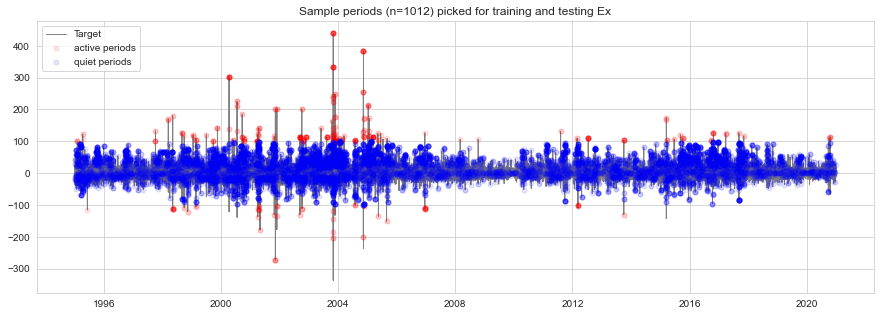

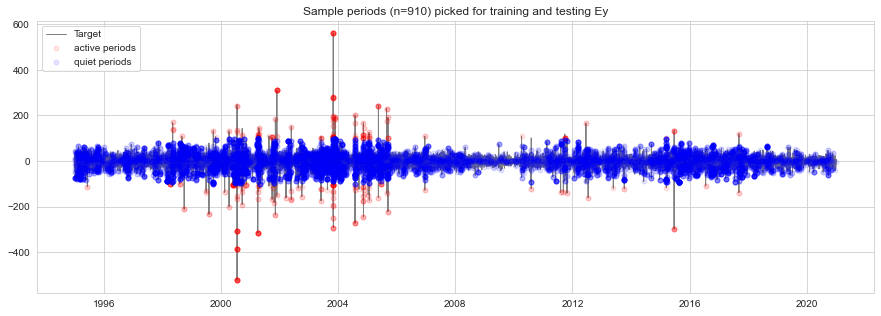

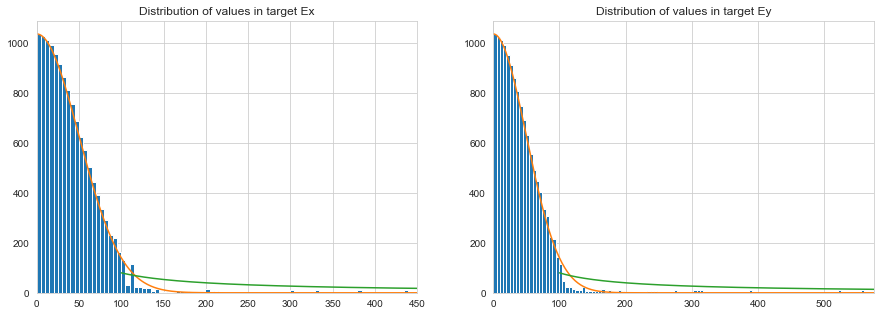

In [15]:
from scipy.stats import norm

# PLOT OF SAMPLES
# ----------------
alpha_dots = 0.1
input_time = df_features.index.to_numpy()
fig = plt.figure(figsize=(15,5))
plt.plot_date(input_time, target_raw_Ex, '-', c='gray', lw=1, label='Target')
plt.plot_date(input_time[i_max_Ex], target_raw_Ex[i_max_Ex], 'ro', ms=5, alpha=alpha_dots, label='active periods')
plt.plot_date(input_time[i_quiet_Ex], target_raw_Ex[i_quiet_Ex], 'bo', ms=5, alpha=alpha_dots, label='quiet periods')
plt.title("Sample periods (n={}) picked for training and testing Ex".format(2*len(i_max_Ex)))
plt.legend(loc='upper left')
if P_LSTM['savefig']:
    plt.savefig(os.path.join(P_LSTM['plotpath'],"sampling_{}.png".format(P_Ex['variable'])))
else:
    plt.show()

fig = plt.figure(figsize=(15,5))
plt.plot_date(input_time, target_raw_Ey, '-', c='gray', lw=1, label='Target')
plt.plot_date(input_time[i_max_Ey], target_raw_Ey[i_max_Ey], 'ro', ms=5, alpha=alpha_dots, label='active periods')
plt.plot_date(input_time[i_quiet_Ey], target_raw_Ey[i_quiet_Ey], 'bo', ms=5, alpha=alpha_dots, label='quiet periods')
plt.title("Sample periods (n={}) picked for training and testing Ey".format(2*len(i_max_Ey)))
plt.legend(loc='upper left')
if P_LSTM['savefig']:
    plt.savefig(os.path.join(P_LSTM['plotpath'],"sampling_{}.png".format(P_Ey['variable'])))
else:
    plt.show()


# DISTRIBUTION OF VALUES
# -----------------------
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.hist(np.hstack((np.abs(target_raw_Ex)[i_quiet_Ex], np.abs(target_raw_Ex)[i_max_Ex])),
         bins=int(min_level/(min_level/level_splits)) + max_level_splits_Ex)
x = np.arange(0,600)
ax1.plot(x, norm.pdf(x,0,50)*pdf_mult)
ax1.plot(x[100:], sw2gic.high_val_decay(x[100:]))
ax1.set_title("Distribution of values in target Ex")
ax2.hist(np.hstack((np.abs(target_raw_Ey)[i_quiet_Ey], np.abs(target_raw_Ey)[i_max_Ey])), 
         bins=int(min_level/(min_level/level_splits)) + max_level_splits_Ey)
ax2.plot(x, norm.pdf(x,0,50)*pdf_mult)
ax2.plot(x[100:], sw2gic.high_val_decay(x[100:]))
ax2.set_title("Distribution of values in target Ey")
ax1.set_xlim([0., (20+max_level_splits_Ex)*5+10])
ax2.set_xlim([0., (20+max_level_splits_Ey)*5+10])
if P_LSTM['savefig']:
    plt.savefig(os.path.join(P_LSTM['plotpath'],"dist_{}{}.png".format(P_LSTM['train_on_x'], P_LSTM['train_on_y'])))
else:
    plt.show()

### Define Features and Targets

In [16]:
# These are the splits in years used for training, validation and testing
# See appendix for how these are determined
train_years = [[1995, 1996, 1997, 1998, 1999], [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], [2018]]
test_years = [[2000, 2001], [2017], [2019, 2020]]
print("Using time ranges:")
print("Training:", train_years)
print("Testing:", test_years)

# Periods to extract:
i_all_Ex = np.array(sorted(i_max_Ex + i_quiet_Ex))
i_all_Ey = np.array(sorted(i_max_Ey + i_quiet_Ey))

# Do for TRAIN / TEST / VAL
df_features_train, ix_train_true, ix_train_adj = sw2gic.extract_datasets_by_years(df_features, train_years, i_all_Ex)
df_features_test, ix_test_true, ix_test_adj = sw2gic.extract_datasets_by_years(df_features, test_years, i_all_Ex)

_, iy_train_true, iy_train_adj = sw2gic.extract_datasets_by_years(df_features, train_years, i_all_Ey)
_, iy_test_true,  iy_test_adj = sw2gic.extract_datasets_by_years(df_features, test_years, i_all_Ey)

print("")
print("EX")
print("Training data points:\t", len(ix_train_true))
print("Testing data points:\t", len(ix_test_true))
print("")
print("EY")
print("Training data points:\t", len(iy_train_true))
print("Testing data points:\t", len(iy_test_true))

Using time ranges:
Training: [[1995, 1996, 1997, 1998, 1999], [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], [2018]]
Testing: [[2000, 2001], [2017], [2019, 2020]]

EX
Training data points:	 10614
Testing data points:	 2737

EY
Training data points:	 10628
Testing data points:	 2652


In [17]:
# Test the index extraction worked as it should, otherwise everything is broken:
if (df_features_train.iloc[ix_train_adj][P_Ex['variable']].mean() == df_features.iloc[ix_train_true][P_Ex['variable']].mean()):
    print("Train set: indices for 'true'/'adj' match. No problem here.")
else:
    print("--- WARNING! Indices for 'true'/'adj' in training don't match!")
    
if (df_features_test.iloc[ix_test_adj][P_Ex['variable']].mean() == df_features.iloc[ix_test_true][P_Ex['variable']].mean()):
    print("Test set:  indices for 'true'/'adj' match. No problem here.")
else:
    print("--- WARNING! Indices for 'true'/'adj' in testing don't match!")
    
# Check there's no overlap between training and testing:
if len(np.intersect1d(df_features_train.index.to_numpy(), df_features_test.index.to_numpy())) > 0.:
    print("WARNING ---- DATA LEAKAGE!")
else:
    print("All good.")

Train set: indices for 'true'/'adj' match. No problem here.
Test set:  indices for 'true'/'adj' match. No problem here.
All good.


#### Include a cut-off point, above which E-field does not increase

In [18]:
max_E_lim = P_LSTM['max_E_lim']

# Positive:
df_features_train.loc[df_features_train[P_Ex['variable']] > max_E_lim, P_Ex['variable']] = max_E_lim
df_features_test.loc[df_features_test[P_Ex['variable']] > max_E_lim, P_Ex['variable']] = max_E_lim
df_features_train.loc[df_features_train[P_Ey['variable']] > max_E_lim, P_Ey['variable']] = max_E_lim
df_features_test.loc[df_features_test[P_Ey['variable']] > max_E_lim, P_Ey['variable']] = max_E_lim

# Negative:
df_features_train.loc[df_features_train[P_Ex['variable']] < -max_E_lim, P_Ex['variable']] = -max_E_lim
df_features_test.loc[df_features_test[P_Ex['variable']] < -max_E_lim, P_Ex['variable']] = -max_E_lim
df_features_train.loc[df_features_train[P_Ey['variable']] < -max_E_lim, P_Ey['variable']] = -max_E_lim
df_features_test.loc[df_features_test[P_Ey['variable']] < -max_E_lim, P_Ey['variable']] = -max_E_lim

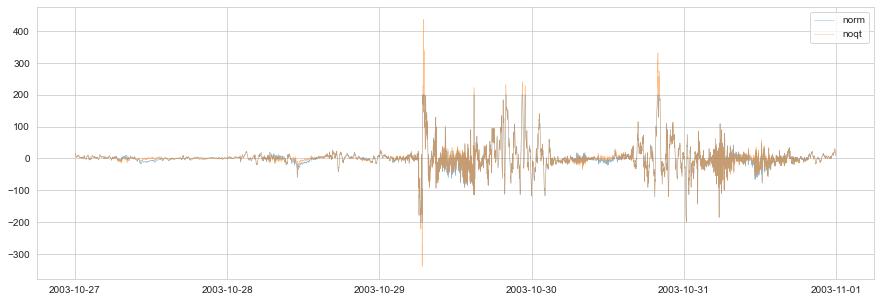

In [19]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_features_train['Ex_FUR'][datetime(2003,10,27):datetime(2003,11,1)], lw=0.5, alpha=0.5, label='norm')
plt.plot(df_features_train['Ex_FUR_noqt'][datetime(2003,10,27):datetime(2003,11,1)], lw=0.5, alpha=0.5, label='noqt')
plt.legend()
plt.show()

### Create arrays

Notes
- Including local-time variables greatly improves the accuracy. It does mean that the daily variations are a large part of the analysis, though.

#### Extracting samples

In [20]:
# ------------------------------------------------------------------------------------------------
from sw2gic import extract_feature_samples, create_target_array, create_persistence_array
# ------------------------------------------------------------------------------------------------

# Remove indices outside of randomly shifted time series
# -------------------------------------------------------
def remove_buffer_i(inds, ip_tr, op_tr, os_tr, df_len):
    '''Provide array of indices, input timerange (ip_tr), output timerange (op_tr),
    and offset timerange (os_tr).'''
    
    inds_red = inds[np.where(np.logical_and(inds >= (ip_tr+os_tr+op_tr/2), 
                                            inds < (df_len - (op_tr+os_tr+op_tr/2))))]
    inds_red = inds_red.astype(int)

    return inds_red


def extract_and_save_target(df, varname, i_true, i_adj, op_tr, os_tr, ip_tr, savepath, SWEncoder, df_X=[], max_val=None, scaler=None):
    
    i_red = remove_buffer_i(i_adj, ip_tr, op_tr, os_tr, len(df))
    
    # CREATE ARRAY OF FEATURE SAMPLES (X)
    if len(df_X) == 0:
        df_X = df
    X, i_clean = extract_feature_samples(df_X, i_red, SWEncoder, op_tr, ip_tr, os_tr)
    
    # CREATE ARRAY OF TARGETS (Y)
    y, sign = create_target_array(df, varname, i_clean, op_tr, max_val=max_val, scaler=scaler)
    y = np.hstack((y, sign.reshape(-1,1)))
    
    # CREATE ARRAY OF PERSISTENCE (PERS) FOR COMPARISON
    y_pers, sign_pers = create_persistence_array(df, varname, i_clean, op_tr, os_tr)
    y_pers = np.hstack((y_pers.reshape(-1,1), sign_pers.reshape(-1,1)))
    
    print("Data sizes\n-----------")
    print("Input shape (train):\t\t{}".format(X.shape))
    print("Output shape:\t\t\t{}".format(y.shape))
    print("Persis. shape:\t\t\t{}".format(y_pers.shape))
    
    # Save data to file:
    np.savez(savepath, X=X, y=y, pers=y_pers, i_true=i_true, i_adj=i_adj, i_clean=i_clean)
    print("File saved to {}.".format(savepath))
    print("")

In [21]:
# Parameters:
ip_tr, op_tr, os_tr = P_LSTM['input_tr'], P_LSTM['output_tr'], P_LSTM['offset_tr']
prefix_train, prefix_test = 'traindata', 'testdata'
datapath = P_LSTM['datapath']
suffix = '_{:04d}_{:04d}_{:04d}'.format(ip_tr, op_tr, os_tr)

# Create scaler objects:
scaler_Ex = MinMaxScaler()
scaler_Ex.fit(np.abs(df_features_train[P_Ex['variable']].to_numpy()).reshape(-1,1))
pickle.dump(scaler_Ex, open(os.path.join(datapath,'scaler_{}.pkl'.format(P_Ex['variable'])), 'wb'))
P_Ex['scaler'] = scaler_Ex
scaler_Ey = MinMaxScaler()
scaler_Ey.fit(np.abs(df_features_train[P_Ey['variable']].to_numpy()).reshape(-1,1))
pickle.dump(scaler_Ey, open(os.path.join(datapath,'scaler_{}.pkl'.format(P_Ey['variable'])), 'wb'))
P_Ey['scaler'] = scaler_Ey

# Ex training dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_train, P_Ex['variable'], suffix))
extract_and_save_target(df_features_train, P_Ex['variable'], ix_train_true, ix_train_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, scaler=P_Ex['scaler'], max_val=max_E_lim)

# Ey training dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_train, P_Ey['variable'], suffix))
extract_and_save_target(df_features_train, P_Ey['variable'], iy_train_true, iy_train_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, scaler=P_Ey['scaler'], max_val=max_E_lim)

# Ex testing dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_test, P_Ex['variable'], suffix))
extract_and_save_target(df_features_test, P_Ex['variable'], ix_test_true, ix_test_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, scaler=P_Ex['scaler'], max_val=max_E_lim)

# Ey testing dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_test, P_Ey['variable'], suffix))
extract_and_save_target(df_features_test, P_Ey['variable'], iy_test_true, iy_test_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, scaler=P_Ey['scaler'], max_val=max_E_lim)

# Load data from file:
#savepath_x = os.path.join(datapath, 'traindata_{}.npz'.format(P_Ex['variable']))
#savepath_y = os.path.join(datapath, 'traindata_{}.npz'.format(P_Ey['variable']))
#npzfile = np.load(savepath_x)
#X_train, y_train, pers_train = npzfile['X'], npzfile['y'], npzfile['pers']
#i_train = npzfile['i_clean']
# Load scalers from file:
#scaler_Ex = pickle.load(open(os.path.join(datapath,'scaler_{}_{:04d}.pkl'.format(P_Ex['variable'], P_LSTM['input_tr'])), 'rb'))
#scaler_Ey = pickle.load(open(os.path.join(datapath,'scaler_{}_{:04d}.pkl'.format(P_Ey['variable'], P_LSTM['input_tr'])), 'rb'))

Ignored 14.0% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(9131, 120, 24)
Output shape:			(9131, 2)
Persis. shape:			(9131, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/traindata_Ex_FUR_0120_0040_0010.

Ignored 12.9% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(9257, 120, 24)
Output shape:			(9257, 2)
Persis. shape:			(9257, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/traindata_Ey_FUR_0120_0040_0010.

Ignored 10.4% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(2451, 120, 24)
Output shape:			(2451, 2)
Persis. shape:			(2451, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/testdata_Ex_FUR_0120_0040_0010.

Ignored 10.8% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(2366, 120, 24)
Output shape:			(2366, 2)
Persis. shape:			(2366, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/testdata_Ey_FUR_0120_0040_0

## 2.2 Extract samples for GICs from fit

Extracting samples...


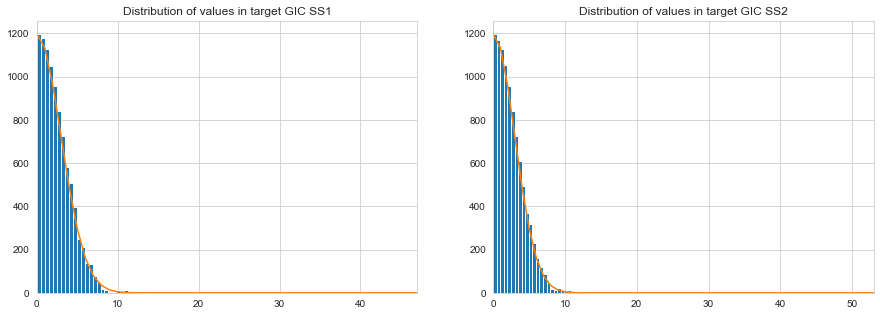

In [22]:
df_features_gic = pd.read_pickle(os.path.join(P_LSTM['datapath'], "df_features_gic.p"))
df_features_gic['speed'] = df_features['speed'].to_numpy()

var_SS1, var_SS5 = 'GIC_fit_SS1', 'GIC_fit_SS5'

target_raw_SS1, target_raw_SS5 = df_features_gic[var_SS1].to_numpy(), df_features_gic[var_SS5].to_numpy()

oversample_by = {8: 2, 15: 3, 25: 5}
min_level = 8
binsize = 0.5
level_splits = min_level/binsize
pdf_var = 3
pdf_mult = 9000.

print("Extracting samples...")
i_quiet_SS1, i_max_SS1, max_level_splits_SS1 = sw2gic.sample_quiet_and_active_times(target_raw_SS1, P_LSTM['input_tr'], min_level=min_level,
                                                                             binsize=binsize, a_gauss=pdf_mult, var_gauss=pdf_var, oversample_by=oversample_by)
i_quiet_SS5, i_max_SS5, max_level_splits_SS5 = sw2gic.sample_quiet_and_active_times(target_raw_SS5, P_LSTM['input_tr'], min_level=min_level,
                                                                             binsize=binsize, a_gauss=pdf_mult, var_gauss=pdf_var, oversample_by=oversample_by)

# DISTRIBUTION OF VALUES
# -----------------------
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.hist(np.hstack((np.abs(target_raw_SS1)[i_quiet_SS1], np.abs(target_raw_SS1)[i_max_SS1])),
         bins=int(min_level/(min_level/level_splits)) + max_level_splits_SS1)
x = np.arange(0,600)
ax1.plot(x, norm.pdf(x,0,pdf_var)*pdf_mult)
ax1.set_title("Distribution of values in target GIC SS1")
ax2.hist(np.hstack((np.abs(target_raw_SS5)[i_quiet_SS5], np.abs(target_raw_SS5)[i_max_SS5])), 
         bins=int(min_level/(min_level/level_splits)) + max_level_splits_SS5)
ax2.plot(x, norm.pdf(x,0,pdf_var)*pdf_mult)
ax2.set_title("Distribution of values in target GIC SS5")
ax1.set_xlim([0., 5+max_level_splits_SS1])
ax2.set_xlim([0., 5+max_level_splits_SS5])
plt.show()

In [23]:
# Periods to extract:
i_all_SS1 = np.array(sorted(i_max_SS1 + i_quiet_SS1))
i_all_SS5 = np.array(sorted(i_max_SS5 + i_quiet_SS5))

df_gic_train, i1_train_true, i1_train_adj = sw2gic.extract_datasets_by_years(df_features_gic, train_years, i_all_SS1)
df_gic_test, i1_test_true, i1_test_adj =    sw2gic.extract_datasets_by_years(df_features_gic, test_years, i_all_SS1)

_, i2_train_true, i2_train_adj = sw2gic.extract_datasets_by_years(df_features_gic, train_years, i_all_SS5)
_, i2_test_true, i2_test_adj =   sw2gic.extract_datasets_by_years(df_features_gic, test_years, i_all_SS5)

# Adjust maximum values:
max_GIC_lim = 15
P_LSTM['max_GIC_lim'] = max_GIC_lim

for var_SS in [var_SS1, var_SS5]:
    # Positive:
    df_gic_train.loc[df_gic_train[var_SS] > max_GIC_lim, var_SS] = max_GIC_lim
    df_gic_test.loc[df_gic_test[var_SS] > max_GIC_lim, var_SS] = max_GIC_lim
    # Negative:
    df_gic_train.loc[df_gic_train[var_SS] < -max_GIC_lim, var_SS] = -max_GIC_lim
    df_gic_test.loc[df_gic_test[var_SS] < -max_GIC_lim, var_SS] = -max_GIC_lim

# Parameters:
ip_tr, op_tr, os_tr = P_LSTM['input_tr'], P_LSTM['output_tr'], P_LSTM['offset_tr']
prefix_train, prefix_test = 'traindata', 'testdata'
datapath = P_LSTM['datapath']
suffix = '_{:04d}_{:04d}_{:04d}'.format(ip_tr, op_tr, os_tr)

# Create scaler objects:
scaler_SS1 = MinMaxScaler()
scaler_SS1.fit(np.abs(df_gic_train[var_SS1].to_numpy()).reshape(-1,1))
pickle.dump(scaler_SS1, open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS1)), 'wb'))
scaler_SS5 = MinMaxScaler()
scaler_SS5.fit(np.abs(df_gic_train[var_SS5].to_numpy()).reshape(-1,1))
pickle.dump(scaler_SS5, open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS5)), 'wb'))

# SS1 training dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_train, var_SS1, suffix))
extract_and_save_target(df_gic_train, var_SS1, i1_train_true, i1_train_adj, op_tr, os_tr, ip_tr, filepath,
                        SWEncoder, df_X=df_features_train, scaler=scaler_SS1, max_val=max_GIC_lim)

# SS5 training dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_train, var_SS5, suffix))
extract_and_save_target(df_gic_train, var_SS5, i2_train_true, i2_train_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, df_X=df_features_train, scaler=scaler_SS5, max_val=max_GIC_lim)

# SS1 testing dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_test, var_SS1, suffix))
extract_and_save_target(df_gic_test, var_SS1, i1_test_true, i1_test_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, df_X=df_features_test, scaler=scaler_SS1, max_val=max_GIC_lim)

# SS5 testing dataset:
filepath = os.path.join(datapath, '{}_{}{}'.format(prefix_test, var_SS5, suffix))
extract_and_save_target(df_gic_test, var_SS5, i2_test_true, i2_test_adj, op_tr, os_tr, ip_tr, filepath, 
                        SWEncoder, df_X=df_features_test, scaler=scaler_SS5, max_val=max_GIC_lim)

Ignored 14.1% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(6357, 120, 24)
Output shape:			(6357, 2)
Persis. shape:			(6357, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/traindata_GIC_fit_SS1_0120_0040_0010.

Ignored 13.7% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(6603, 120, 24)
Output shape:			(6603, 2)
Persis. shape:			(6603, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/traindata_GIC_fit_SS2_0120_0040_0010.

Ignored 10.6% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(1891, 120, 24)
Output shape:			(1891, 2)
Persis. shape:			(1891, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/testdata_GIC_fit_SS1_0120_0040_0010.

Ignored 9.1% of data contaminated by NaNs in data set.
Data sizes
-----------
Input shape (train):		(1829, 120, 24)
Output shape:			(1829, 2)
Persis. shape:			(1829, 2)
File saved to /Volumes/Mnemosyne/Data/ML/SW2GIC/testdata_GIC_

#### Show example of data

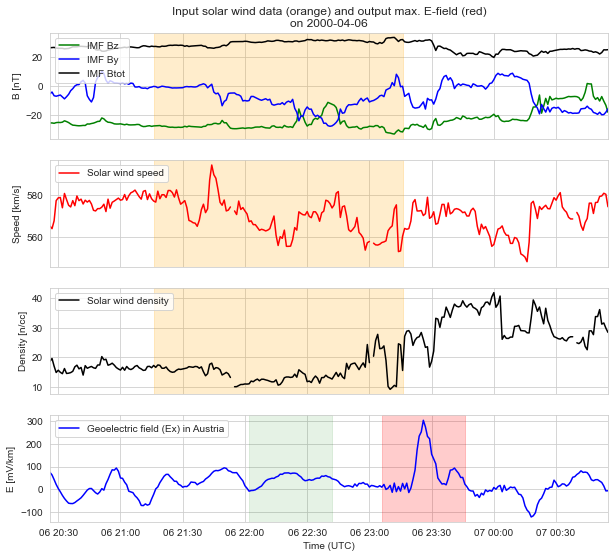

In [24]:
i_max_max = int(ix_test_true[np.argmax(df_features.iloc[ix_test_true][P_Ex['variable']])]) # Maximum of active times
buffer_time = P_LSTM['input_tr'] + 60
buffer_inds = np.arange(0,len(df_features))[i_max_max - buffer_time:i_max_max + int(buffer_time/2)]

def calc_t_pers_back(speed):
    '''Calculates the time it took solar wind to propagate from L1 to Earth at 'speed'.
    Returned in minutes as int.'''
    dist_to_L1 = 1496547.603
    return int(dist_to_L1 / speed / 60.)

# For persistence variable:
avg_speed = df_features.iloc[i_max_max-20:i_max_max]['speed'].mean()
t_pers_back = calc_t_pers_back(avg_speed) # .sw2gic

# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
ax1.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['bz'], 'g-', label="IMF Bz")
ax1.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['by'], 'b-', label="IMF By")
ax1.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['btot'], 'k-', label="IMF Btot")
ax2.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['speed'], 'r-', label="Solar wind speed")
ax3.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['density'], 'k-', label="Solar wind density")
for ax in [ax1, ax2, ax3]:
    ax.axvspan(df_features.iloc[i_max_max-P_LSTM['input_tr']-P_LSTM['offset_tr']].name, 
               df_features.iloc[i_max_max-P_LSTM['offset_tr']].name, alpha=0.2, color='orange')
ax4.plot_date(df_features.iloc[buffer_inds].index, df_features.iloc[buffer_inds]['Ex_FUR'], 'b-', label="Geoelectric field (Ex) in Austria")
ax4.axvspan(df_features.iloc[i_max_max-int(P_LSTM['output_tr']/2)].name, 
            df_features.iloc[i_max_max+int(P_LSTM['output_tr']/2)].name, alpha=0.2, color='red')
ax4.axvspan(df_features.iloc[i_max_max-t_pers_back-P_LSTM['output_tr']].name, 
            df_features.iloc[i_max_max-t_pers_back].name, alpha=0.1, color='green')
#ax4.annotate(s='20 min', xy=(df_features_train.iloc[i_max_max-P_LSTM['offset_tr']].name,250),
#             xytext=(df_features_train.iloc[i_max_max-int(P_LSTM['output_tr']/2)].name,300),
#             arrowprops=dict(arrowstyle='<->'))
for ax in [ax1, ax2, ax3, ax4]:
    ax.legend(loc="upper left")
ax4.set_xlim([df_features.iloc[buffer_inds[0]].name, df_features.iloc[buffer_inds[-1]].name])
ax4.set_xlabel("Time (UTC)")
ax1.set_ylabel("B [nT]")
ax2.set_ylabel("Speed [km/s]")
ax3.set_ylabel("Density [n/cc]")
ax4.set_ylabel("E [mV/km]")
ax1.set_title("Input solar wind data (orange) and output max. E-field (red)\non {}".format(df_features.iloc[buffer_inds[0]].name.to_pydatetime().strftime("%Y-%m-%d")))
plt.savefig(os.path.join(P_LSTM['plotpath'],"example_{}.png".format(P_Ex['variable'])), dpi=400)
if P_LSTM['savefig']:
    plt.savefig(os.path.join(P_LSTM['plotpath'],"example_{}_{}.png".format(P_Ex['variable'], suffix)))
else:
    plt.show()

# 3. Write samples for virtual real-time application

Create arrays for model as if it had been run every 15 minutes for the testing dataset years 2001, 2017, 2019, and 2020.

No need to run everything else to do this part - just do general imports and read the input parameters.

In [25]:
# ------------------------------------------------------------------------------------------------
from sw2gic import extract_feature_samples, create_target_array, create_persistence_array
# ------------------------------------------------------------------------------------------------

rtyears = [2000, 2001, 2017, 2019, 2020]
run_model_every = 15 # minutes
ip_tr, op_tr, os_tr = P_LSTM['input_tr'], P_LSTM['output_tr'], P_LSTM['offset_tr']
datapath = P_LSTM['datapath']
suffix = '_{:04d}_{:04d}_{:04d}'.format(ip_tr, op_tr, os_tr)

# Load processed feature data:
filename_start = 'df_features_proc'
proc_filename =  "{}_{}_{}.p".format(filename_start, start_datacut.strftime("%Y%m%d"), end_datacut.strftime("%Y%m%d"))
pickled_data_processed = os.path.join(ml_data_path, proc_filename)
df_features = pd.read_pickle(pickled_data_processed)

# ... and GIC data:
df_features_gic = pd.read_pickle(os.path.join(P_LSTM['datapath'], "df_features_gic.p"))
df_features_gic['speed'] = df_features['speed'].to_numpy()

# Load scalers from file:
var_SS1_fit, var_SS5_fit = 'GIC_fit_SS1', 'GIC_fit_SS5'
scaler_Ex = pickle.load(open(os.path.join(datapath,'scaler_{}.pkl'.format(P_Ex['variable'])), 'rb'))
scaler_Ey = pickle.load(open(os.path.join(datapath,'scaler_{}.pkl'.format(P_Ey['variable'])), 'rb'))
scaler_SS1_fit = pickle.load(open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS1_fit)), 'rb'))
scaler_SS5_fit = pickle.load(open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS5_fit)), 'rb'))

# Create scaler objects:
var_SS1_meas, var_SS5_meas = 'GIC_SS1', 'GIC_SS5'
scaler_SS1 = MinMaxScaler()
scaler_SS1.fit(np.abs(df_features_gic[var_SS1_meas].to_numpy()).reshape(-1,1))
pickle.dump(scaler_SS1, open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS1_meas)), 'wb'))
scaler_SS5 = MinMaxScaler()
scaler_SS5.fit(np.abs(df_features_gic[var_SS5_meas].to_numpy()).reshape(-1,1))
pickle.dump(scaler_SS5, open(os.path.join(datapath,'scaler_{}.pkl'.format(var_SS5_meas)), 'wb'))


def extract_and_save_target_rt(df, varname, X_rt, inds, op_tr, os_tr, ip_tr, savepath, i_nans, scaler=None):

    y_rt, sign_rt = create_target_array(df, varname, inds, op_tr, scaler=scaler)
    y_rt = np.hstack((y_rt, sign_rt.reshape(-1,1)))

    pers_rt, pers_rt_sign = create_persistence_array(df, varname, inds, op_tr, os_tr)
    pers_rt = np.hstack((pers_rt.reshape(-1,1), pers_rt_sign.reshape(-1,1)))

    # Save realtime application data to file:
    np.savez(savepath, X=X_rt, y=y_rt, pers=pers_rt, i_clean=inds, i_nans=i_nans)

    
for rtyear in rtyears:
    
    print("Creating real-time arrays for {}...".format(rtyear))
    start_rt, end_rt = datetime(rtyear,1,1), datetime(rtyear+1,1,1)
    prefix = 'rtdata{}'.format(rtyear)

    # Read data
    # ----------
    df_rt = df_features[start_rt:end_rt-timedelta(minutes=1)]
    df_rt_gic = df_features_gic[start_rt:end_rt-timedelta(minutes=1)]
        
    # Find indices for every point of run_model_every:
    n_sections = int(len(df_rt)/run_model_every)
    i_rt = np.arange(int(np.ceil((ip_tr+os_tr)/run_model_every)), n_sections) * run_model_every
        
    # First: find out how many nans are in the data
    # Interpolate over all periods of consecutive nans no longer than 16 minutes
    df_rt_int = df_rt.interpolate(method='linear', limit=8, limit_direction='both')
    # Find the mean over areas with leftover nans:
    df_rt_mean = df_rt_int.rolling(window=P_LSTM['input_tr'], min_periods=P_LSTM['input_tr']-10, center=True).mean()
    leftover_nans = np.where(np.isnan(df_rt_mean.iloc[i_rt-int(P_LSTM['input_tr']/2)]['speed']))[0]
    print("---- {:.1f}% of data contains too many nans. Indices of nans will be saved.".format(len(leftover_nans)/len(i_rt)*100))
        
    # Then: Interpolate over any gaps
    df_rt = df_rt.interpolate(method='linear', limit_direction='both')
    df_rt_gic = df_rt_gic.interpolate(method='linear', limit_direction='both')

    # ----------------------------
    #         FEATURES X
    # ----------------------------
    
    X_rt, i_rt = extract_feature_samples(df_rt, i_rt, SWEncoder, op_tr, ip_tr, os_tr, use_rand_offset=False)

    # ----------------------------
    #     TARGETS EX / EY
    # ----------------------------
    
    for var_E, scaler_E in zip([P_Ex['variable'], P_Ey['variable']], [scaler_Ex, scaler_Ey]):
        filepath_E = os.path.join(P_LSTM['datapath'], '{}_{}{}'.format(prefix, var_E, suffix))
        extract_and_save_target_rt(df_rt, var_E, X_rt, i_rt, op_tr, os_tr, ip_tr, filepath_E, leftover_nans, scaler=scaler_E)
    
    # ----------------------------
    #     TARGETS GIC_FIT
    # ----------------------------
    
    for var_SS, scaler_SS in zip([var_SS1_fit, var_SS5_fit], [scaler_SS1_fit, scaler_SS5_fit]):
        filepath_SS_fit = os.path.join(P_LSTM['datapath'], '{}_{}{}'.format(prefix, var_SS, suffix))        
        extract_and_save_target_rt(df_rt_gic, var_SS, X_rt, i_rt, op_tr, os_tr, ip_tr, filepath_SS_fit, leftover_nans, scaler=scaler_SS)
    
    # ----------------------------
    #     TARGETS GIC_OBS
    # ----------------------------
    
    # Measured GIC data:
    if rtyear >= 2017:
        print("Also reading and writing GIC measurements...")
        
        for var_SS, scaler_SS in zip([var_SS1_meas, var_SS5_meas], [scaler_SS1, scaler_SS5]):
            filepath_SS = os.path.join(P_LSTM['datapath'], '{}_{}{}'.format(prefix, var_SS, suffix))
            extract_and_save_target_rt(df_rt_gic, var_SS, X_rt, i_rt, op_tr, os_tr, ip_tr, filepath_SS, leftover_nans, scaler=scaler_SS)
        
    print("")
print("Done.")

Creating real-time arrays for 2000...
---- 6.8% of data contains too many nans. Indices of nans will be saved.
Ignored 0.0% of data contaminated by NaNs in data set.

Creating real-time arrays for 2001...
---- 8.8% of data contains too many nans. Indices of nans will be saved.
Ignored 0.0% of data contaminated by NaNs in data set.

Creating real-time arrays for 2017...
---- 12.2% of data contains too many nans. Indices of nans will be saved.
Ignored 0.0% of data contaminated by NaNs in data set.
Also reading and writing GIC measurements...

Creating real-time arrays for 2019...
---- 10.0% of data contains too many nans. Indices of nans will be saved.
Ignored 0.0% of data contaminated by NaNs in data set.
Also reading and writing GIC measurements...

Creating real-time arrays for 2020...
---- 5.0% of data contains too many nans. Indices of nans will be saved.
Ignored 0.0% of data contaminated by NaNs in data set.
Also reading and writing GIC measurements...

Done.


## Appendix - Train/test/val split by years (calculation)

Some extra stuff.

In [24]:
pickled_data_path = os.path.join(ml_data_path, 'df_features.p')
df_features_all = pd.read_pickle(pickled_data_path)

In [25]:
all_std_x, all_std_y, all_years = [], [], []
all_years_x = {}
for year in range(start_datacut.year,end_datacut.year):
    year_cut = df_features_all[datetime(year,1,1):datetime(year+1,1,1)][['Ex_FUR', 'Ey_FUR', 'Bx_FUR', 'By_FUR']]
    year_cut = year_cut.dropna()
    std_x = year_cut['Ex_FUR'].std()
    std_y = year_cut['Ey_FUR'].std()
    print("{}\t{:.3f}\t{:.3f}".format(year, std_x, std_y))
    all_std_x.append(std_x)
    all_std_y.append(std_y)
    all_years.append(year)
    all_years_x[year] = std_x

1995	6.566	5.604
1996	5.559	4.649
1997	5.274	4.496
1998	6.803	5.880
1999	7.056	5.920
2000	8.099	7.296
2001	7.763	6.679
2002	7.235	5.934
2003	9.644	9.068
2004	7.475	6.390
2005	7.001	6.607
2006	5.519	4.554
2007	4.977	4.174
2008	4.802	3.912
2009	3.862	2.946
2010	4.730	3.748
2011	5.630	4.539
2012	5.978	4.963
2013	5.382	4.419
2014	5.853	4.387
2015	6.928	6.098
2016	6.303	5.220
2017	5.983	5.236
2018	4.866	4.075
2019	4.562	3.769
2020	4.373	3.371


#### Balance train/validation/test

We make the split between train, validation and test into roughly 3/5, 1/5 and 1/5 from the 26 years (16, 5 and 5). Iterate through the configurations to balance the distributions of the sets according to these criteria:
1. 2003 is part of the training set.
2. 2017 is part of the test set (as the only recent stormy period).
3. The two most recent years belong to the test dataset.
4. The datasets have nearly equal yearly standard variations (in general, std_x ~= std_y).
5. Train, test, and validation sets all have data from two different solar cycles (yearsplit = 2007).

In [26]:
train_years = list(range(1995, 2021))
yearsplit = 2007
year1, yearlast = train_years[0], train_years[-1]
nval1, nval2 = 3, 2
ntest1, ntest2 = 2, 2
must_be_in_train = 2003
must_be_in_test = 2017
best_std = 1.
for iv1 in range(0, yearsplit-year1-(nval1-1)): # val first set
    for iv2 in range(0, yearlast+1-yearsplit-nval2-ntest2+1): # val second set
        val_years = list(range(year1+iv1,year1+iv1+nval1))
        val_years += list(range(yearsplit+iv2,yearsplit+iv2+nval2))
        #print(iv1, iv2, it1, val_years, test_years)
        for it1 in range(0, yearsplit-year1-ntest1+1):
            test_years = list(range(yearlast-ntest2+1,yearlast+1))
            test_years += list(range(year1+it1,year1+it1+ntest1))
            test_years += [must_be_in_test]
            if must_be_in_train not in val_years+test_years and set(val_years).isdisjoint(test_years):
                #print(iv1, iv2, it1, val_years, test_years)

                train_years = list(range(1995, 2021))
                for y in test_years+val_years:
                    train_years.remove(y)
                std_train, std_test, std_val = 0, 0, 0
                for year in all_years:
                    if year in train_years:
                        #print(year, "Train")
                        std_train += all_years_x[year]
                    elif year in test_years:
                        #print(year, "Test")
                        std_test += all_years_x[year]
                    elif year in val_years:
                        #print(year, "Val")
                        std_val += all_years_x[year]
                # Find the std between the groups of years to minimise differences
                new_std = np.std([std_train/len(train_years), std_test/len(test_years), std_val/len(val_years)])
                if new_std < best_std:
                    print("New best! {:.4f} --".format(new_std), val_years, test_years)
                    print("{:.2f} {:.2f} {:.2f}".format(std_train/len(train_years), std_val/len(val_years), std_test/len(test_years)))
                    best_std = new_std
                    test_final = copy.copy(test_years)
                    val_final = copy.copy(val_years)
                    train_final = copy.copy(train_years)
print("Training years:\n", sorted(train_final))
print("Validation years:\n", sorted(val_final))
print("Testing years:\n", sorted(test_final))

New best! 0.3974 -- [1995, 1996, 1997, 2007, 2008] [2019, 2020, 1998, 1999, 2017]
6.39 5.44 5.76
New best! 0.3634 -- [1995, 1996, 1997, 2007, 2008] [2019, 2020, 1999, 2000, 2017]
6.31 5.44 6.01
New best! 0.3412 -- [1995, 1996, 1997, 2010, 2011] [2019, 2020, 1998, 1999, 2017]
6.36 5.55 5.76
New best! 0.2989 -- [1995, 1996, 1997, 2010, 2011] [2019, 2020, 1999, 2000, 2017]
6.27 5.55 6.01
New best! 0.2360 -- [1995, 1996, 1997, 2011, 2012] [2019, 2020, 1998, 1999, 2017]
6.28 5.80 5.76
New best! 0.1615 -- [1995, 1996, 1997, 2011, 2012] [2019, 2020, 1999, 2000, 2017]
6.20 5.80 6.01
New best! 0.0470 -- [1995, 1996, 1997, 2014, 2015] [2019, 2020, 1999, 2000, 2017]
6.12 6.04 6.01
New best! 0.0469 -- [1995, 1996, 1997, 2015, 2016] [2019, 2020, 1999, 2000, 2017]
6.10 6.13 6.01
New best! 0.0442 -- [1995, 1996, 1997, 2015, 2016] [2019, 2020, 2000, 2001, 2017]
6.05 6.13 6.16
New best! 0.0396 -- [1996, 1997, 1998, 2014, 2015] [2019, 2020, 1999, 2000, 2017]
6.11 6.08 6.01
New best! 0.0395 -- [1996, 199

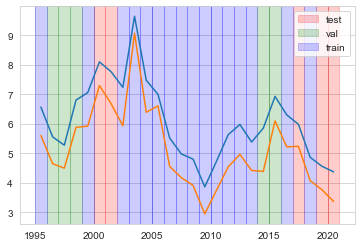

In [27]:
plt.plot(np.array(all_years)+0.5, all_std_x)
plt.plot(np.array(all_years)+0.5, all_std_y)
for year in test_final:
    if year == test_final[0]:
        plt.axvspan(year, year+1, alpha=0.2, color='red', label="test")
    else:
        plt.axvspan(year, year+1, alpha=0.2, color='red')
for year in val_final:
    if year == val_final[0]:
        plt.axvspan(year, year+1, alpha=0.2, color='green', label="val")
    else:
        plt.axvspan(year, year+1, alpha=0.2, color='green')
for year in train_final:
    if year == train_final[0]:
        plt.axvspan(year, year+1, alpha=0.2, color='blue', label="train")
    else:
        plt.axvspan(year, year+1, alpha=0.2, color='blue')
plt.legend()